# Global Geospatial Analysis of Meteorite Landings & UFO Sightings
The data set consists of 2 variables
- Meteorite Landings
- UFO Sightings

with GPS coordinates (called [*geodetic* coordinates](https://en.wikipedia.org/wiki/Geodetic_datum#Geodetic_coordinates)) of each event throughout the planet.
These data will be given a basic geospatial analysis.

## [GIS](https://en.wikipedia.org/wiki/Geographic_information_system) Database Setup
SQLite3 has GIS database extension, [SpatiaLite](https://www.gaia-gis.it/fossil/libspatialite/home), to work with geospatial information.
- Define an SQLAlchemy event listener to automatically load the extension on connections.
- Create an engine for a new database (overwriting if necessary).
- Create and load database metadata.

In [1]:
import sqlalchemy as sa
import sqlalchemy_views as sav
DB = 'db.sqlite'

def load_spatialite(con, record):
    '''Load SpatiaLite extension for SQLite.'''
    con.enable_load_extension(True)
    con.load_extension('mod_spatialite')
def initialize_spatialite(con, record):
    '''Load SpatiaLite extension for SQLite.'''
    load_spatialite(con, record)
    con.execute('SELECT InitSpatialMetaData(TRUE)')
def create_engine(path=DB, replace=True, *args, **kwargs):
    '''Create an engine linked to a database, and delete existing database at path unless replace is False.'''
    import pathlib as pl
    if path:
        db = pl.Path(path)
        if replace and db.exists():
            db.unlink()
        uri = f'sqlite:///{db}'
    else:
        uri = 'sqlite://'
    engine = sa.create_engine(uri, *args, **kwargs)
    sa.event.listen(engine, 'connect', load_spatialite)
    sa.event.listen(engine, 'first_connect', initialize_spatialite)
    return engine

engine = create_engine()
meta = sa.schema.MetaData()
meta.reflect(bind=engine)

By default, all SQLite tables have an implicit `ROWID` column.
SpatiaLite relies on it healvily.

In [2]:
def rowid_column():
    '''Generate ROWID column definition.'''
    return sa.Column('ROWID', sa.types.Integer, system=True)

GeoAlchemy extends SQLAlchemy with geospatial features.
- Define a Geometry SQL type preset with SpatiaLite defaults.
- Define some SpatiaLite functions.

In [3]:
import geoalchemy2 as ga
class Geometry(ga.Geometry):
    '''Geometry optimized for SpatiaLite'''
    def __init__(self, geometry_type='GEOMETRY', srid=-1, dimension=2, spatial_index=True, management=True, use_typmod=None, use_st_prefix=False, *args, **kwargs):
        '''Initialize a geometry type that by default adds the geometry column after table creation and calls GIS functions without prefix.'''
        super().__init__(geometry_type=geometry_type, srid=srid, dimension=dimension, spatial_index=spatial_index, management=management, use_typmod=use_typmod, use_st_prefix=use_st_prefix, *args, **kwargs)
class MakePoint(ga.functions.GenericFunction):
    name = 'MakePoint'
    type = Geometry
class BuildMBR(ga.functions.GenericFunction):
    name = 'BuildMBR'
    type = Geometry
class ScaleCoordinates(ga.functions.GenericFunction):
    name = 'ScaleCoordinates'
    type = Geometry
class ST_SquareGrid(ga.functions.GenericFunction):
    name = 'ST_SquareGrid'
    type = Geometry

Importing data into SpatiaLite requires converting shapes into [Well-Known Text format](https://en.wikipedia.org/wiki/Well-known_text) with an embedded Spatial Reference system ID (SRID).
[SRID EPSG:4326](https://epsg.io/4326) is the standard geodetic coordinate reference system used for GPS.

In [4]:
import geoalchemy2.elements as gae
def to_wkt(df, srid=-1, index=False):
    '''Normalize data frame geometry for export.'''
    df = df.copy()
    df[df.geometry.name] = df.geometry.apply(lambda x: gae.WKTElement(x.wkt if x else x, srid, use_st_prefix=False))
    return (value._asdict() for value in df.itertuples(index=index))

[SpatiaLite features a `SpatialIndex` as a virtual table for optimizing queries](https://www.gaia-gis.it/fossil/libspatialite/wiki?name=SpatialIndex).
Let's streamline access to it.

In [5]:
spatial_index = sa.Table('SpatialIndex', meta,
                         rowid_column(),
                         autoload_with=engine,
                         extend_existing=True)
def spatial_optimizer(table, search_frame, column_name=None, table_key='ROWID'):
    '''
    Return an optimizing query for narrowing down `table` records in the vicinity of `search_frame`.

    Parameters
    ----------
    `table`: an SQLAlchemy table or view of geometric records to filter.
    Its metadata must expose the system ROWID column or an integer primary key named by `table_key`.
    
    `search_frame`: an SQLAlchemy expression of type geometry.
    
    `column_name`: optional string to specify which geometry column in the table to filter.
    Only needed when the table has multiple geometry columns.
    
    `table_key`: optional string naming `table`'s implicit ROWID or alias column. defaults to ``'ROWID'``.
    '''
    return table.columns[table_key].in_(
        sa.select(
            (spatial_index.columns['ROWID'],),
            whereclause=sa.and_(
                spatial_index.columns['f_table_name'] == sa.literal(table.name),
                *((spatial_index.columns['f_geometry_column'] == sa.literal(column_name),) if column_name
                 else ()),
                spatial_index.columns['search_frame'] == search_frame
            )
        )
    )

SpatiaLite has a convenient function for dropping geometry tables/views and their supporting data structures.

In [6]:
def drop_geo(connection, table):
    '''Drop entire geometry table/view including supporting metadata.'''
    return connection.execute(sa.func.DropGeoTable(table.name))

Tables often include columns of enumerated values that normalize as separate tables.
This function facilitates the process.

In [7]:
def unjoin(series):
    '''Split `series` into a foreign key relationship with indexed values.'''
    values = pd.Series(series.dropna().unique()).sort_values().values
    parent = pd.Series(values, name=series.name)
    return series.map(pd.Series(parent.index.values, index=values)), parent
def export_enum(connection, table, data):
    '''Insert `data`, a dataframe of indexed names, into a `table` with id & name columns through `connection`.'''
    return connection.execute(
        sa.insert(table),
        tuple({'id': idv, 'name': name} for (idv, name) in pd.DataFrame(data).itertuples())
    )

Compensate for SQLite's lack of `FULL JOIN` with a substitute.

In [8]:
def full_join(left, right, columns, onclause=None, left_key='ROWID'):
    '''
    Return an SQLAlchemy clause equivalent to FULL JOIN between `left` & `right` tables selecting `columns` on `onclause`.
    
    Parameters
    ----------
    `left`: ``sqlalchemy.sql.expression.FromClause`` for the left table
    
    `right`: ``sqlalchemy.sql.expression.FromClause`` for the right table
    
    `columns`: a ``Sequence`` of ``sqlalchemy.sql.expression.ColumnElement`` or ``sqlalchemy.sql.expression.FromClause`` for the SELECT columns
    
    `onclause`: ``sqlalchemy.sql.expression.ColumnElement`` for the ON expression
    
    `left_key`: ``string`` naming a unique key for `left`. default: ``'ROWID'``
    '''
    def select(left, right):
        return sa.select(
            columns,
            from_obj=sa.join(left, right, isouter=True, onclause=onclause)
        )
    return sa.union_all(
        select(left, right),
        select(right, left).where(left.columns[left_key].is_(None))
    )

## Geospatial Partition
This analysis partitions the planetary surface into equal area sections, and calculates frequencies over each area per variable.
Since the length of 1° longitude varies by latitude (longest at the equator, 0 at the poles), areas *depend on position* (vary under [rigid transformations](https://en.wikipedia.org/wiki/Rigid_transformation)) in the geodetic coordinate system, so a uniform area partition is non-trivial.
Instead, we can partition the surface in a coordinate system where area is independent of position and transform it to geodetic coordinates.
Moreover, to reduce computation to straight side polygons, it'd be preferable to have some straight lines transform as straight lines between coordinate systems.

The [cylindrical equal-area projection](https://en.wikipedia.org/wiki/Cylindrical_equal-area_projection) meets requirements:
- areas are independent of position
- radial lines from the poles (meridians) and their orthogonals (circles of latitude) are straight, orthogonal lines in both this and geodetic coordinate systems.

[Define the coordinate system in SpatiaLite](http://www.gaia-gis.it/gaia-sins/spatialite-cookbook/html/metadata.html):
- [PROJ](https://proj4.org/index.html), the geospatial transformation backend for all our libraries, [loads the system with string `+proj=cea`](https://proj4.org/operations/projections/cea.html).
- It has [spatial reference ID EPSG:9835](https://epsg.io/9835-method).

The geodetic system, World Geodetic System 1984, which is [EPSG:4326](https://epsg.io/4326), comes preloaded.

In [9]:
import pandas as pd
import geopandas as gpd
geodetic_srid = 4326
cea_srid = 9835

In [10]:
spatial_ref_sys = meta.tables['spatial_ref_sys']
with engine.begin() as connection:
    connection.execute(sa.insert(spatial_ref_sys).prefix_with('OR IGNORE'),
                       srid=cea_srid,
                       auth_name='epsg',
                       auth_srid=cea_srid,
                       ref_sys_name='Cylindrical Equal Area',
                       proj4text='+proj=cea +datum=WGS84 +no_defs',
                       srtext='Undefined')
    df = pd.read_sql(sa.select((spatial_ref_sys,),
                               whereclause=spatial_ref_sys.columns['srid'].in_((cea_srid, geodetic_srid))),
                     connection,
                     index_col='srid')
df

,auth_name,auth_srid,ref_sys_name,proj4text,srtext
srid,,,,,
4326,epsg,4326,WGS 84,+proj=longlat +datum=WGS84 +no_defs,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS..."
9835,epsg,9835,Cylindrical Equal Area,+proj=cea +datum=WGS84 +no_defs,Undefined


With the coordinate system defined, we may partition the surface.
Though SpatiaLite's rectangular grid generator, [SquareGrid](http://www.gaia-gis.it/gaia-sins/spatialite-sql-4.3.0.html#p0), only generates squares, we can scale them into rectangles that fill the space precisely.
- Transform the 1st quadrant corner (180°, 90°) as a boundary reference point.
- Map an `nx`:`ny` rectangle (created with `BuildMbr`) to a grid that fills that rectangle with `nx`×`ny` squares.
- Scale the grid to boundaries of the cylindrical coordinate space & transform to geodetic coordinates.

The expression returns the partition as a single multipolygon.

In [11]:
def geopartition():
    '''Return an ``sqlalchemy.sql.expression`` with ``Integer`` parameters nx, ny that returns a MULTIPOLYGON that partitions geodetic coordinate space into nx * ny equal area rectangles.'''
    two = sa.bindparam('two', 2)
    cea = sa.bindparam('cea', cea_srid)
    geodetic = sa.bindparam('geodetic', geodetic_srid)
    parameter = sa.sql.expression.CTE(sa.select((
        sa.sql.expression.label('nx', sa.bindparam('nx', type_=sa.types.Integer)),
        sa.sql.expression.label('ny', sa.bindparam('ny', type_=sa.types.Integer)),
        sa.sql.expression.label('corner', ga.functions.ST_Transform(MakePoint(180, 90, geodetic), cea))
    )))
    nx_parameter = parameter.columns['nx']
    ny_parameter = parameter.columns['ny']
    corner = parameter.columns['corner']
    return ga.functions.ST_Transform(
        ScaleCoordinates(
            ST_SquareGrid(
                BuildMBR(-nx_parameter, -ny_parameter, nx_parameter, ny_parameter, cea),
                two,
                False,
                MakePoint(nx_parameter % two,
                          ny_parameter % two,
                          cea)),
            ga.functions.ST_X(corner) / nx_parameter,
            ga.functions.ST_Y(corner) / ny_parameter),
        geodetic)

## Create Partition Table 
Create a table, `partition`, containing MULTIPOLYGON partition in a single row.
`NumGeometries` counts the individual polygons.

In [12]:
partition = sa.Table('partition', meta,
                     sa.Column('id', sa.Integer, primary_key=True),
                     sa.Column('geometry', Geometry('MULTIPOLYGON', geodetic_srid)))
partition_geometry = partition.columns['geometry']

In [13]:
with engine.begin() as connection:
    drop_geo(connection, partition)
    meta.create_all(connection, (partition,))
    connection.execute(
        sa.insert(partition).from_select(
            (partition_geometry,),
            geopartition()),
        nx=90,
        ny=45)
    df = pd.read_sql(sa.func.NumGeometries(partition_geometry),
                    connection)
df

,NumGeometries_1
0,4050


For analysis, we'll need individual polygons from the multipolygon.
[The virtual table `ElementaryGeometries` extracts multigeometries into constituents if provided a table name and row ID](https://www.gaia-gis.it/fossil/libspatialite/wiki?name=VirtualElementary).

Define `section` as a table of all partition constituents: though a view is possible, we need the spatial index a table provides.

In [14]:
meta.remove(sa.Table('section', meta))
section = sa.Table('section', meta,
                   rowid_column(),
                   sa.Column('id', sa.types.Integer, primary_key=True),
                   sa.Column('geometry', Geometry('POLYGON', geodetic_srid)))
elementary_geometries = sa.Table('ElementaryGeometries', meta,
                                 rowid_column(),
                                 sa.Column('geometry', Geometry()),
                                 autoload_with=engine,
                                 extend_existing=True)
with engine.begin() as connection:
    drop_geo(connection, section)
    section.create(connection)
    connection.execute(
        section.insert().from_select(
            ('id', 'geometry'),
            sa.select(
                tuple(elementary_geometries.columns[name] for name in ('ROWID', 'geometry')),
                whereclause=sa.and_(
                    elementary_geometries.columns['f_table_name'] == sa.literal(partition.name),
                    elementary_geometries.columns['origin_rowid'] == partition.columns['id'])
            )
        )
    )
    df = pd.read_sql(sa.select((sa.func.count(),), from_obj=section), connection)
df

,count_1
0,4050


## Create Meteorite Landings Table
### Import
Load geospatial [Meteorite Landings data](https://data.nasa.gov/Space-Science/Meteorite-Landings/gh4g-9sfh) into a GeoDataFrame.

In [15]:
df = gpd.read_file('meteorite.geojson')
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
mass                           972 non-null object
name                           1000 non-null object
:@computed_region_cbhk_fwbd    133 non-null object
reclong                        988 non-null object
geolocation_address            0 non-null object
geolocation_zip                0 non-null object
year                           999 non-null object
geolocation_state              0 non-null object
fall                           1000 non-null object
id                             1000 non-null object
:@computed_region_nnqa_25f4    134 non-null object
recclass                       1000 non-null object
reclat                         988 non-null object
geolocation_city               0 non-null object
nametype                       1000 non-null object
geometry                       988 non-null object
dtypes: object(16)
memory usage: 125.1+ KB


### Sanitize
`id` field is a column of unique, non-null values, making it eligible as an index/primary key.

In [16]:
df['id'].nunique() == df.shape[0]

True

[GeoJSON](https://tools.ietf.org/html/rfc7946) specifications stipulate
> GeoJSON uses a geographic coordinate reference system, [World Geodetic System 1984](https://epsg.io/4326), and units of decimal degrees.

[World Geodetic System 1984 is EPSG 4326](https://epsg.io/4326).
GeoPandas honors this.

In [17]:
df.crs

{'init': 'epsg:4326'}

The geometry field is uniformly Point type.

In [18]:
df.geom_type.dropna().eq('Point').all()

True

- Drop unused columns.
- Convert `id` to an index.
- Verify `mass` matches numeric syntax.

In [19]:
import functools as ft
import operator as op
df = df.drop(
    labels=df.columns[
        ft.reduce(
            op.or_,
            (df.columns.str.startswith(value) for value in ('geolocation', ':@computed', 'recl'))
        )
    ].tolist() + ['nametype'],
    axis=1
).set_index('id')
df['mass'].str.match(r'\d*(?:\.\d*)?').all()

True

- Convert `mass` to numeric.
- Verify all dates are years.

In [20]:
df['mass'] = pd.to_numeric(df.loc[:, 'mass'])
df['year'].str.endswith('01-01T00:00:00').all()

True

- Convert years to integers.
- Identify columns lacking NULLs.

In [21]:
df['year'] = df['year'].dropna().apply(lambda x: int(pd.Period(x, freq='Y').year))
df.notna().all()

mass        False
name         True
year        False
fall         True
recclass     True
geometry    False
dtype: bool

- In field `recclass`, replace the string `'Unknown'` with `None`.
- Coordinates (0, 0) are out in the ocean.
  Unless people look for meteorites at the bottom of the ocean, these points should be NULL.

In [22]:
index = df['recclass']
df['recclass'] = index.where(~index.eq('Unknown'), None)
df.loc[df.geometry.loc[df.geometry.notna()].cx[0, 0].index, df.geometry.name] = None
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1000 entries, 1 to 24019
Data columns (total 6 columns):
mass        972 non-null float64
name        1000 non-null object
year        999 non-null float64
fall        1000 non-null object
recclass    998 non-null object
geometry    986 non-null object
dtypes: float64(2), object(4)
memory usage: 94.7+ KB


### Save

Factor `fall` & `recclass` out.

In [23]:
df['fall'], fall_data = unjoin(df['fall'])
df['recclass'], recclass_data = unjoin(df['recclass'])

Define geometry type & table/view schemas.

In [24]:
point_type = Geometry('POINT', geodetic_srid)
for name in ('fall', 'recclass', 'meteorite', 'meteorite_all'):
    meta.remove(sa.Table(name, meta))
fall = sa.Table('fall', meta,
                sa.Column('id', sa.Integer, primary_key=True),
                sa.Column('name', sa.Text, nullable=False, unique=True))
recclass = sa.Table('recclass', meta,
                    sa.Column('id', sa.Integer, primary_key=True),
                    sa.Column('name', sa.Text, nullable=False, unique=True))
meteorite = sa.Table('meteorite', meta,
                     rowid_column(),
                     sa.Column('id', sa.Integer, primary_key=True),
                     sa.Column('mass', sa.Float()),
                     sa.Column('name', sa.Text),
                     sa.Column('year', sa.Integer),
                     sa.Column('fall', sa.Integer, sa.ForeignKey(fall.columns['id']), index=True),
                     sa.Column('recclass', sa.Integer, sa.ForeignKey(recclass.columns['id']), index=True),
                     sa.Column('geometry', point_type))
meteorite_all = sa.Table('meteorite_all', meta)

- Write the data frame into tables.
- Create a view joining them together.
- Link the view to the geometry table's index to enhance queries.
- Read it back.

In [25]:
with engine.begin() as connection:
    for table in (meteorite_all, meteorite):
        drop_geo(connection, table)
    meta.drop_all(connection, (meteorite_all, meteorite, fall, recclass))
    meta.create_all(connection, (fall, recclass, meteorite))
    for pair in ((fall, fall_data), (recclass, recclass_data)):
        export_enum(connection, *pair)
    connection.execute(sa.insert(meteorite), tuple(to_wkt(df, geodetic_srid)))
    connection.execute(sav.CreateView(
        meteorite_all,
        sa.select(tuple(meteorite.columns[name] for name in ('id', 'mass', 'name', 'year'))
                  + (fall.columns['name'].label('fall'),
                     recclass.columns['name'].label('recclass'),
                     sa.column('geometry')),
                  from_obj=meteorite.join(fall, isouter=True).join(recclass, isouter=True))
        ))
    connection.execute(sa.insert(meta.tables['views_geometry_columns']).prefix_with('OR REPLACE'),
                       view_name='meteorite_all',
                       view_geometry='geometry',
                       view_rowid='id',
                       f_table_name='meteorite',
                       f_geometry_column='geometry',
                       read_only=False)
    meteorite_all = sa.Table('meteorite_all', meta,
                             sa.Column('geometry', point_type),
                             autoload_with=connection,
                             extend_existing=True)
    df = gpd.read_postgis(sa.sql.select((meteorite_all,)), connection, 'geometry').drop('id', axis=1)
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
mass        972 non-null float64
name        1000 non-null object
year        999 non-null float64
fall        1000 non-null object
recclass    998 non-null object
geometry    986 non-null object
dtypes: float64(2), object(4)
memory usage: 47.0+ KB


## Create UFO Sightings Table
### Import
Import select columns from [UFO Sightings](https://www.kaggle.com/NUFORC/ufo-sightings) & rename a column.

In [26]:
df = pd.read_csv('ufo.csv', usecols=[0, 4, 5, 6, 7, 9, 10]).rename(mapper={'duration (seconds)': 'duration'}, axis=1)
df.info()

/home/luism/.pyenv/versions/miniconda3-latest/envs/geospatial/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 7 columns):
datetime                80332 non-null object
shape                   78400 non-null object
duration                80332 non-null object
duration (hours/min)    80332 non-null object
comments                80317 non-null object
latitude                80332 non-null object
longitude               80332 non-null float64
dtypes: float64(1), object(6)
memory usage: 4.3+ MB


### Sanitize
We'll need to frequently convert data.
Let's a define a function to ease that.
- Convert `datetime` and check the first few invalid input values.

In [27]:
def coerce(converter, series, *args, **kwargs):
    '''Convert the series with converter, and return the new series & NULL value mask.'''
    new_series = converter(series, errors='coerce', *args, **kwargs)
    return new_series, new_series.isna()
datetime, invalid = coerce(pd.to_datetime, df.loc[:, 'datetime'], infer_datetime_format=True)
df.loc[invalid].head()

,datetime,shape,duration,duration (hours/min),comments,latitude,longitude
388,10/11/2006 24:00,oval,120,a min or two,I was walking from the garage to the house&#44...,43.2127778,-75.456111
693,10/1/2001 24:00,other,6312000,2 years,go to: http://www.24horas.com.pe/data/videos/...,-5.129547,-80.120569
962,10/1/2012 24:00,triangle,300,5 minutes,V shaped and 8 big and very brite lights&#44mo...,42.4805556,-83.475556
1067,10/12/2003 24:00,disk,22,22 seconds,UFO in Salatiga&#44Indonesia,-7.33683,110.498817
1221,10/12/2013 24:00,fireball,300,3-5 minutes,A bright orange light split into four&#44 did ...,39.1619444,-84.456944


These datetimes have an invalid hour: 24.
It's the same issue for all datetimes.

In [28]:
df.loc[invalid, 'datetime'].str.contains(r'\b24:').all()

True

- Map all these datetimes to the next day at 00:00 and convert them: all datetimes convert.
- Convert duration to numeric & examine conversion failures.

In [29]:
datetime[invalid] = pd.to_datetime(df.loc[invalid, 'datetime'].str.replace('24:00$', '00:00'), infer_datetime_format=True) + pd.Timedelta(days=1)
df['datetime'] = datetime
duration, invalid = coerce(pd.to_numeric, df.loc[:, 'duration'])
df.loc[invalid]

,datetime,shape,duration,duration (hours/min),comments,latitude,longitude
27822,2000-02-02 19:33:00,NaN,2`,each a few seconds,Driving through Plomosa Pass towards Bouse Loo...,33.9325000,-114.005000
35692,2005-04-10 22:52:00,NaN,8`,eight seconds,2 red lights moving together and apart with a ...,36.9741667,-122.029722
58591,2006-07-21 13:00:00,circle,0.5`,1/2 segundo,Viajaba a 27.000 pies en un avion comercial ve...,4.440663,-75.244141


Judging from the redundant `duration (hours/min)` field, the issue is stray punctuation.
- Drop the redundant column.
- Remove stray punctuation & convert.
- Convert latitude to numeric.
- Examine conversion failures.

In [30]:
df = df.drop('duration (hours/min)', axis=1)
duration[invalid] = pd.to_numeric(df.loc[invalid, 'duration'].str.replace(r'[^\d.-]', ''))
df['duration'] = duration
latitude, invalid = coerce(pd.to_numeric, df.loc[:, 'latitude'])
df.loc[invalid]

,datetime,shape,duration,comments,latitude,longitude
43782,1974-05-22 05:30:00,rectangle,180.0,Huge rectangular object emmitting intense whit...,33q.200088,-105.624152


Another stray character.
- Remove stray characters & convert.
- Strip spaces from the ends of column names.

In [31]:
latitude[invalid] = pd.to_numeric(df.loc[invalid, 'latitude'].str.replace(r'[^\d.-]', ''))
df['latitude'] = latitude
df = df.rename(mapper=str.strip, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 6 columns):
datetime     80332 non-null datetime64[ns]
shape        78400 non-null object
duration     80332 non-null float64
comments     80317 non-null object
latitude     80332 non-null float64
longitude    80332 non-null float64
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 3.7+ MB


Convert the DataFrame into a GeoDataFrame with coordinates as Points.
We'll assume geodetic coordinates, since those are the predominant standard.

In [32]:
import itertools as it
import shapely.geometry as sg
# %debug
df = gpd.GeoDataFrame(
    df.assign(
        geometry=df.apply(
            lambda x: sg.Point(x['longitude'], x['latitude']),
            axis=1
        )
    ).drop(
        ['longitude', 'latitude'],
        axis=1
    ),
    geometry='geometry',
    crs={'init': f'epsg:{geodetic_srid}'})
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 5 columns):
datetime    80332 non-null datetime64[ns]
shape       78400 non-null object
duration    80332 non-null float64
comments    80317 non-null object
geometry    80332 non-null object
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 3.1+ MB


Convert missing `shape` values to `None`.

In [33]:
df['shape'] = df['shape'].where(pd.notna, None)

### Save

Factor the data frame for normalization.

In [34]:
df['shape'], shape_data = unjoin(df['shape'])

Define tables/views.

In [35]:
for name in ('shape', 'ufo', 'ufo_all'):
    meta.remove(sa.Table(name, meta))
shape = sa.Table('shape', meta,
                 sa.Column('id', sa.Integer, primary_key=True),
                 sa.Column('name', sa.Text, nullable=False, unique=True))
ufo = sa.Table('ufo', meta,
               rowid_column(),
               sa.Column('id', sa.Integer, primary_key=True),
               sa.Column('datetime', sa.DateTime),
               sa.Column('shape', sa.Integer, sa.ForeignKey(shape.columns['id']), index=True),
               sa.Column('duration', sa.Float()),
               sa.Column('comments', sa.Text),
               sa.Column('geometry', point_type))
ufo_all = sa.Table('ufo_all', meta)

- Create tables/views.
- Link view to geometry table's spatial index.
- Read data back.

In [36]:
with engine.begin() as connection:
    for table in (ufo_all, ufo):
        drop_geo(connection, table)
    meta.drop_all(connection, (ufo_all, ufo, shape))
    meta.create_all(connection, (shape, ufo))
    export_enum(connection, shape, shape_data)
    connection.execute(sa.sql.insert(ufo), tuple(to_wkt(df, geodetic_srid)))
    connection.execute(sav.CreateView(
        ufo_all,
        sa.select(tuple(ufo.columns[name] for name in ('id', 'datetime', 'duration', 'comments'))
                  + (shape.columns['name'].label('shape'),
                     sa.column('geometry')),
                  from_obj=ufo.join(shape, isouter=True))
    ))
    connection.execute(sa.insert(meta.tables['views_geometry_columns']).prefix_with('OR REPLACE'),
                       view_name='ufo_all',
                       view_geometry='geometry',
                       view_rowid='id',
                       f_table_name='meteorite',
                       f_geometry_column='geometry',
                       read_only=False)
    ufo_all = sa.Table('ufo_all', meta,
                       sa.Column('geometry', point_type),
                       autoload_with=connection,
                       extend_existing=True)
    df = gpd.read_postgis(sa.sql.select((ufo_all,)), connection, 'geometry').drop('id', axis=1)
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 5 columns):
datetime    80332 non-null datetime64[ns]
duration    80332 non-null float64
comments    80317 non-null object
shape       78400 non-null object
geometry    80332 non-null object
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 3.1+ MB


## Analysis
Let's visualize the meteorite landings & UFO sightings with point plots on a map.
- Define some functions to read geometries from the database and plot them.
- For a global map, use the [Mollweide projection](https://proj4.org/operations/projections/moll.html).

In [37]:
import geoplot as gplt
import matplotlib.pyplot as plt
def read_geometry(connection, table):
    '''Read a geometry column from a table into a GeoDataFrame and return it.'''
    return gpd.read_postgis(
        sa.select((table.columns['geometry'],), whereclause=table.columns['geometry'].isnot(None)),
        connection,
        geom_col='geometry'
    )
def plot_global(plotter, proj, df, subplot=None, **kwargs):
    '''Plot the data frame with plotter & projection, and render the map's outline, coast lines for the entire globe.'''
    ax = plotter(
        df, projection=proj,
        ax=plt.subplot(*subplot, projection=proj) if subplot else None,
        **kwargs
    )
    ax.outline_patch.set_visible(True)
    ax.coastlines()
    ax.set_global()
    return ax
def pointplot(proj, df, subplot=None):
    '''Plot data frame with red points.'''
    return plot_global(gplt.pointplot, proj, df, subplot=subplot, color='r')
def kdeplot(proj, df, subplot=None):
    '''Plot kernel density estimate using shading & the Epanechnikov kernel.'''
    return plot_global(gplt.kdeplot, proj, df, subplot=subplot, kernel='epa', shade=True)
def choropleth(proj, df, hue, subplot=None):
    '''Plot shaded polygons according to the column named by hue with a horizontal legend.'''
    return plot_global(gplt.choropleth, proj, df, subplot=subplot, hue=hue, k=None, cmap='Blues', legend=True, legend_kwargs={'orientation': 'horizontal'})
projection = gplt.crs.Mollweide()

From the database, import point geometry data for meteorite landings & UFO sightings.

In [38]:
with engine.begin() as connection:
    df_meteorite = read_geometry(connection, meteorite)
    df_ufo = read_geometry(connection, ufo)

Plot the points in adjacent subplots.

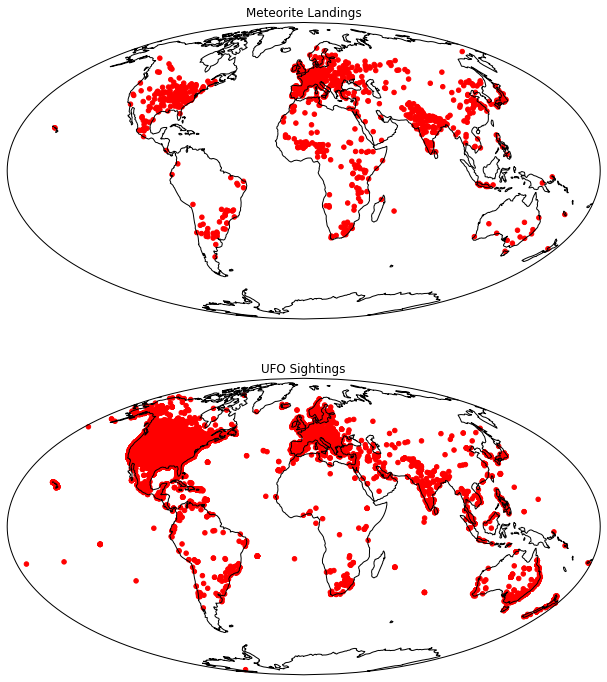

In [39]:
plt.figure(figsize=(12, 12))
pointplot(projection, df_meteorite, subplot=(2, 1, 1))
plt.title('Meteorite Landings')
pointplot(projection, df_ufo, subplot=(2, 1, 2))
plt.title('UFO Sightings')
plt.show()

I plotted the data with adjacent panels due to the heavy overlap of points obstructing each other's view.
These maps look remarkably similar with points possibly concentrated around populated areas with enough technological access to reporting systems.
Are the data correlated?

Though the visualizations show spatial distribution, they don't show frequency.
[Kernel density estimates](https://en.wikipedia.org/wiki/Kernel_density_estimation) can show that more effectively.

/home/luism/.pyenv/versions/miniconda3-latest/envs/geospatial/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


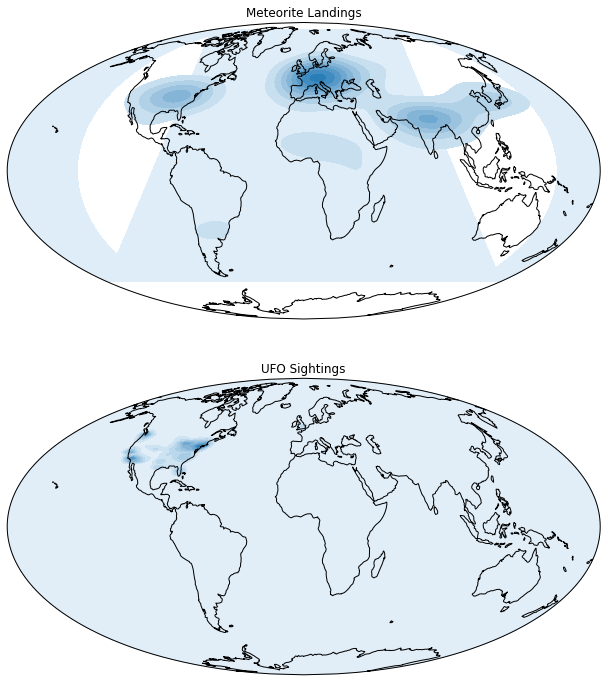

In [40]:
plt.figure(figsize=(12, 12))
kdeplot(projection, df_meteorite, subplot=(2, 1, 1))
plt.title('Meteorite Landings')
kdeplot(projection, df_ufo, subplot=(2, 1, 2))
plt.title('UFO Sightings')
plt.show()

In [41]:
del df_meteorite, df_ufo

These plots tell a different story.
Meteorite landing reports concentrate most around North America, Europe, India, and East Asia
However, UFO sightings are diffuse: the only areas with relatively highs concentration occur in North America, indicating self-selective reporting bias.
The data source explains this bias is real: [NUFORC](https://en.wikipedia.org/wiki/National_UFO_Reporting_Center) is based in United States and primarily reports from there, though it gathers global reports, too.

To calculate correlations, we'll convert reports into random variables of their counts over regions.
Our regions will be the partition sections we created before.
To truly partition the data, we must assign each report to a unique section.
- Define a function to create a view of counts over sections.
  A subquery assigns each point to the first section it intersects before counting.

In [42]:
def create_view_over_section(connection, view, table):
    '''Create a view of counts for records of table and section intersecting.'''
    #drop old view if any
    view.drop(connection, checkfirst=True)
    #prepare subquery associating each table id with 1 section id
    table_id = table.columns['id']
    section_id = section.columns['id']
    table_geometry = table.columns['geometry']
    section_geometry = section.columns['geometry']
    first_section = sa.func.first_value(section_id).over(partition_by=table_id)
    subquery = sa.select(
        (table_id, first_section),
        whereclause=sa.and_(
            spatial_optimizer(table, section_geometry),
            table_geometry.isnot(None),
            ga.functions.ST_Intersects(table_geometry, section_geometry)
        ),
        group_by=table_id,
        order_by=(table_id, section_id)
    ).cte()
    #create a view counting records per section
    create_view = sav.CreateView(
        view,
        sa.select((section_id, sa.func.count().label('count')),
                 from_obj=subquery,
                 whereclause=section_id == subquery.columns[first_section.anon_label],
                 group_by=section_id)
    )
    connection.execute(
        create_view
    )
    view = sa.Table(view.name, meta, extend_existing=True, autoload_with=connection)
    return pd.read_sql_table(view.name, connection, index_col='id')

Prepare metadata to manage our views.

In [43]:
for name in ('meteorite_counts', 'ufo_counts'):
    meta.remove(sa.Table(name, meta))
meteorite_counts = sa.Table('meteorite_counts', meta)
ufo_counts = sa.Table('ufo_counts', meta)

Create views of our random variables.

In [44]:
with engine.begin() as connection:
    df = create_view_over_section(connection, meteorite_counts, meteorite)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385 entries, 568 to 3918
Data columns (total 1 columns):
count    385 non-null int64
dtypes: int64(1)
memory usage: 6.0 KB


In [45]:
with engine.begin() as connection:
    df = create_view_over_section(connection, ufo_counts, ufo)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 11 to 3919
Data columns (total 1 columns):
count    596 non-null int64
dtypes: int64(1)
memory usage: 9.3 KB


To generate visualizations, read into a dataframe a join of these views with section geometries.
Note that mixed joins are not associative, so the join order matters.

In [46]:
with engine.begin() as connection:
    full_count = full_join(
        meteorite_counts,
        ufo_counts,
        columns=(
            sa.func.ifnull(ufo_counts.columns['id'], meteorite_counts.columns['id']).label('id'),
            meteorite_counts.columns['count'].label('meteorite'),
            ufo_counts.columns['count'].label('ufo')
        ),
        onclause=meteorite_counts.columns['id'] == ufo_counts.columns['id'],
        left_key='id'
    ).cte()
    df = gpd.read_postgis(
        sa.select(
            (full_count.columns['id'],)
            + tuple(sa.func.ifnull(full_count.columns[name], 0).label(name)
                    for name in ('meteorite', 'ufo'))
            + (section.columns['geometry'],),
            from_obj=sa.join(
                full_count,
                section,
                onclause=full_count.columns['id'] == section.columns['id']
            )
        ),
        connection,
        geom_col='geometry',
        index_col='id'
    )
engine.dispose()
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 740 entries, 568 to 3919
Data columns (total 3 columns):
meteorite    740 non-null int64
ufo          740 non-null int64
geometry     740 non-null object
dtypes: int64(2), object(1)
memory usage: 23.1+ KB


We're ready to plot.

/home/luism/.pyenv/versions/miniconda3-latest/envs/geospatial/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:696: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-9020047.848073646, top=-9020047.848073646
  self.set_ylim([y1, y2])
/home/luism/.pyenv/versions/miniconda3-latest/envs/geospatial/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:696: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-9020047.848073646, top=-9020047.848073646
  self.set_ylim([y1, y2])


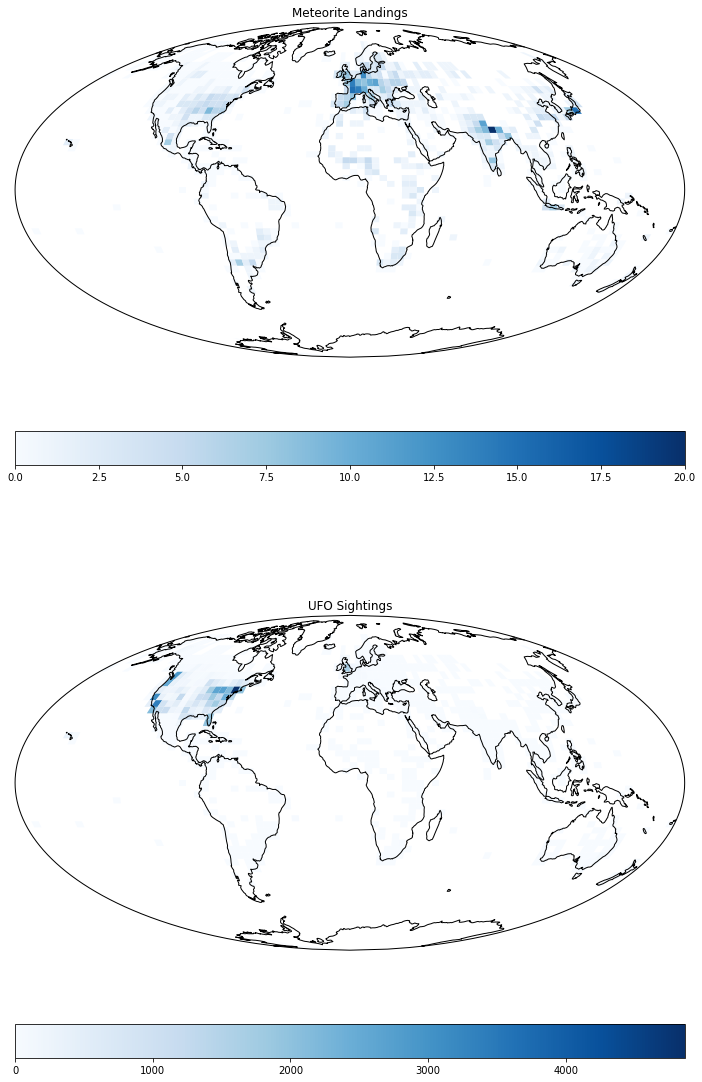

In [47]:
plt.figure(figsize=(12, 20))
choropleth(projection, df, 'meteorite', subplot=(2, 1, 1))
plt.title('Meteorite Landings')
choropleth(projection, df, 'ufo', subplot=(2, 1, 2))
plt.title('UFO Sightings')
plt.show()

Despite distortions due to the projection, each section has equal area.

These plots look similar to the previous kernel density estimates, as they should.
For the UFO data, the high frequency range with skew toward North America corroborates reporting bias.
From the plot legends, we have far more data on UFO sightings than meteorite landings, confirmed by dataframe summaries.

In [48]:
df.describe()

,meteorite,ufo
count,740.000000,740.000000
mean,1.332432,108.556757
std,2.259313,420.696858
min,0.000000,0.000000
25%,0.000000,1.000000
50%,1.000000,2.000000
75%,2.000000,13.000000
max,20.000000,4864.000000


In [49]:
df.sum()

meteorite      986
ufo          80332
dtype: int64

The tremendous difference between the maximum & 75% quantile of UFO reports (4864 vs 13) indicates staggering levels of reports coming from some regions compared to the rest of the world, revealing the magnitude of bias or disproportionate activity.
The total observation counts (the sums), show we have about 80 times more information on UFO reports than meteorites, though this was evident when we initially imported the data.

In [50]:
df.loc[:, 'meteorite':'ufo'].corr()

,meteorite,ufo
meteorite,1.000000,0.126539
ufo,0.126539,1.000000


Despite initial appearances, the correlation between data sets is quite weak (0.126539).
# Conclusion & Discussion
This analysis shows that though the spatial arrangements of meteorite landings & UFO sightings look similar, the reports lack correlation, likely due to UFO reporting bias from North America throwing off correlations.

Some possible directions for further analysis could include of trying to control for report bias, perhaps by analyzing North America and the rest of the world separately.
Our data includes datetimes, so a spatial time series could also be attempted, although the relatively small size of our meteorite data set might limit that.
Another direction could be to import a spatial world population data set and compare our data against it.
Instead of partitioning the globe into equal areas, we might try partitioning or weighting data in proportion to population to achieve another kind of analysis.
Our partition makes no attempt to distinguish land or water, affecting frequencies calculated for coastal areas: a better analysis would account for that.